# Spect_Helper

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import tdt
import os
from process_nwb.wavelet_transform import wavelet_transform

In [2]:
mpl.rcParams['figure.facecolor'] = '1'

## Data

In [69]:
data_directory = r'/Users/vanessagutierrez/Desktop/Rat/RVG02/RVG02_B1'

In [70]:
tdt_data = tdt.read_block(data_directory)
fs = tdt_data['streams']['Wave']['fs']

read from t=0s to t=93.8s


In [71]:
fs_stim_delay = 0.25 * fs

In [72]:
# fs_stim_delay

In [73]:
wave_data = tdt_data.streams.Wave.data

In [74]:
markers = tdt_data.epocs.mark.onset

In [75]:
# markers

In [76]:
marker_onsets = [int(x*fs_stim_delay) for x in markers] 
# multiplies each marker onset sec with the 'fs' to get the timepoints for those secs
# marker_onsets

In [77]:
wave_data.shape # channels x samples

(128, 1144832)

In [78]:
# wave_data

In [79]:
new_wave_data = wave_data.T  # samples x channels
one_channel = new_wave_data[:,82]

In [80]:
one_channel

array([ 125,  139,  140, ..., -317, -307, -322], dtype=int16)

In [81]:
tdt_trials = tdt.epoc_filter(tdt_data, 'mark', t=[-0.8192, 0.8192]) # 10000 before and after onset
trials_list = tdt_trials.streams.Wave.filtered # within each trial, 128 channels with # of samples

In [82]:
# trials_list

In [83]:
chs_ordered = [
       81, 83, 85, 87, 89, 91, 93, 95, 97, 105, 98, 106, 114, 122, 113, 121,
       82, 84, 86, 88, 90, 92, 94, 96, 99, 107, 100, 108, 116, 124, 115, 123,
       66, 68, 70, 72, 74, 76, 78, 80, 101, 109, 102, 110, 118, 126, 117, 125,
       65, 67, 69, 71, 73, 75, 77, 79, 103, 111, 104, 112, 120, 128, 119, 127,
       63, 61, 59, 57, 55, 53, 51, 49, 25, 17, 26, 18, 10, 2, 9, 1,
       64, 62, 60, 58, 56, 54, 52, 50, 27, 19, 28, 20, 12, 4, 11, 3,
       48, 46, 44, 42, 40, 38, 36, 34, 29, 21, 30, 22, 14, 6, 13, 5,
       47, 45, 43, 41, 39, 37, 35, 33, 31, 23, 32, 24, 16, 8, 15, 7
       ]

In [84]:
# trials_mat = np.zeros((num_samples, len(trials_list)))

# for i in np.arange(len(chs_ordered)):
    
#     for tidx, trial in enumerate(trials_list):
#         sub_trial = trial[chs_ordered[i] - 1, :num_samples]
#         trials_mat[:, tidx] = sub_trial 

In [85]:
# type(trials_mat)

## Functions

In [86]:
def get_trials_mat(signal, markers, pre_buf=10000, post_buf=10000):
    """Returns trial matrix
    Args:
        signal (np.array): Signal vector
        markers (list): List of trial onset in samples
        pre_buf (int, optional): Number of samples to pull prior to baseline. Defaults to 10000.
        post_buf (int, optional): Number of samples to pull after. Defaults to 10000.
    Returns:
        trials_mat (np.array): Trial matrix samples by trials
    """
    nsamples = post_buf + pre_buf
    ntrials = len(markers)
    trials_mat = np.empty((nsamples, ntrials))
        
    for idx, marker in enumerate(markers):
        start_frame, end_frame = marker - pre_buf, marker + post_buf
        trials_mat[:, idx] = signal[int(start_frame):int(end_frame)]
    return trials_mat

In [90]:
trials_mat = get_trials_mat(one_channel, marker_onsets)

In [91]:
def zscore_data(tf_data, num_base_pts=200):
    """Compute zscore across trial matrix
    Args:
        tf_data (nparray): Trial matrix of samples x trials
        num_base_pts (int, optional): The first num_base_pts are used for baseline. Defaults to 200.
    Returns:
        tf_norm_data (nparray): Normalized trial matrix
    """
    # Zscore the data
    mean = tf_data[:num_base_pts].mean(axis=0, keepdims=True)
    std = tf_data[:num_base_pts].std(axis=0, keepdims=True)
    tf_norm_data = (tf_data - mean) / std    
    return tf_norm_data

In [92]:
def compute_spectrogram(trials_mat, fs, pre_buf=1500, post_buf=1500, baseline=200):
    """Computes spectrogram using wavelet transform
    Args:
        trials_mat (list): List of np-arrays that contain trial matrices (samples x trials)
        fs (numeric): Sample rate
        pre_buf (int, optional): The number of samples to include prior to sample midpoint of trials_mat. Defaults to 1500.
        post_buf (int, optional): The number of samples to include after the sample midpoint. Defaults to 1500.
        baseline (int, optiona): The first set of samples to include in baseline. Defaults to 200.
    Returns:
        Xnorm, f (nparray, nparray): Returns zscored wavelet magnitude coefficients and corresponding frequencies
    """
    Xh, _, f, _  = wavelet_transform(trials_mat, rate=fs, filters='rat', hg_only=False)
    n = Xh.shape[0] // 2
    Xh = Xh[(n - pre_buf):(n + post_buf), :, :] #throw away edges bc of possible effect affects
    Xh = Xh[:, :, 10:] #throw away low frequencies
    f = f[10:-10]
    Xm = abs(Xh) #take abs value
    Xnorm = zscore_data(Xm, baseline) #zscore 
    return Xnorm, f

In [93]:
Xnorm, f = compute_spectrogram(trials_mat, fs)

In [94]:
Xnorm

array([[[-1.84527450e+00,  1.64135090e+00,  1.67309443e+00, ...,
          3.21613936e-01,  1.35525317e+00,  7.09580207e-01],
        [ 1.66522133e+00, -1.86066910e+00, -1.78166155e+00, ...,
         -2.07582245e+00, -7.20104800e-01, -9.62068519e-01],
        [ 1.75834519e+00, -1.64554239e+00, -1.60071479e+00, ...,
          2.01974687e-01,  1.60919145e+00,  7.95150462e-01],
        ...,
        [ 1.75796264e+00, -1.76422781e+00, -1.65519676e+00, ...,
          9.17727826e-01,  5.08312895e-01,  8.46869241e-01],
        [-1.76668528e+00, -1.73338938e+00, -1.71219551e+00, ...,
         -1.10557049e+00, -5.77607778e-01, -6.05442416e-01],
        [-1.57404759e+00,  1.87252147e+00,  1.70203922e+00, ...,
          3.08716042e+00,  1.25716758e+00, -2.99367417e-01]],

       [[-1.82418401e+00,  1.62649958e+00,  1.65732127e+00, ...,
          5.63855817e-01,  1.50180650e+00,  8.53713083e-01],
        [ 1.64963250e+00, -1.83914861e+00, -1.76260972e+00, ...,
         -2.06698549e+00, -7.00869774e

In [111]:
Xnorm_md = np.median(Xnorm, axis=-1)

In [112]:
Xnorm_md.shape

(3000, 60)

In [113]:
def plot_spectrogram(tf_data, f, tmin, tmax, colorbar=False, ax=None, fig=None):
    """Plots spectrogram
    Args:
        tf_data (nparray): Trial matrix samples x trials
        f (nparray): Frequency vector
        tmin (np.float): X-axis min display time (whatever is specified is what the x-axis will be label irrespective if it is correct)
        tmax (np.float): X-axis max display time (whatever is specified is what the x-axis will be label irrespective if it is correct)
        colorbar (bool, optional): Whether to plot colorbar. Defaults to False.
        ax (class, optional): Matplotlib axes handle. Defaults to None.
        fig (class, optional): Matplotlib figure handle. Defaults to None.
    """
    #tf_data: samples x frequencies
    if (ax is None) or (fig is None):
        fig, ax = plt.subplots(1, 1)
    pos = ax.imshow(tf_data.T, interpolation='none', aspect=1/5, vmin=0, vmax=10, cmap='binary', 
                    origin='lower', extent=[tmin, tmax, f[0], f[-1]])
    if colorbar:
        fig.colorbar(pos, ax=ax)

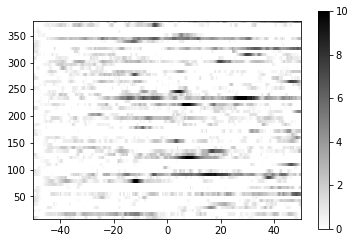

In [114]:
plot_spectrogram(Xnorm_md, f, -50, 50, colorbar=True)
plt.show()

In [145]:
def plot_spectrogram_matrix(data, fs, markers, nrow, ncol, pre_buf=10000, post_buf=10000):
    """Extracts trials, compute wavelet coeffients, takes median across trials and plot spectrogram matrix
    Args:
        data (nparray): Data matrix samples x channels
        f (np.array): Frequency vector
        fs (numeric): Sample rate
        markers (list): List of trial onset times in samples
        nrow (int): Number of rows
        ncol (int): Number of columns
        pre_buf (int): Number of samples to pull prior to stimulus onset
        post_buf (int): Number of samples to pull after stimulus onset
    """
    fig, axs = plt.subplots(nrow, ncol, figsize=(16, 8))
    num_chan = data.shape[1]
    for ch in range(num_chan):
        row, col = ch // ncol, ch % ncol
        ax = axs[row, col]
        trials_mat = get_trials_mat(data[:, ch], markers, pre_buf=pre_buf, post_buf=post_buf)
        tf_data, f = compute_spectrogram(trials_mat, fs)
        tf_data = np.median(tf_data, axis=1)
        plot_spectrogram(tf_data, f, -50, 50, ax=ax, fig=fig)

## John's Example Tests

Test 1: Compute and plot spectrogram

(30000, 10)


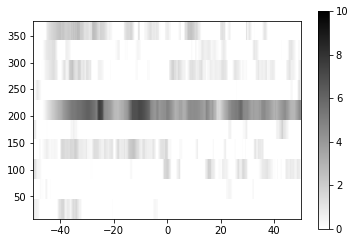

In [134]:
nsamp, nchan = 30000, 10
fs = 30000 #sample rate
trials_mat = np.random.randn(nsamp, nchan)
print(trials_mat.shape)
Xnorm, f = compute_spectrogram(trials_mat, fs)
Xnorm_md = np.median(Xnorm, axis=-1)
plot_spectrogram(Xnorm_md, f, -50, 50, colorbar=True)
plt.show()

Test 2: Plot matrix of spectrogram

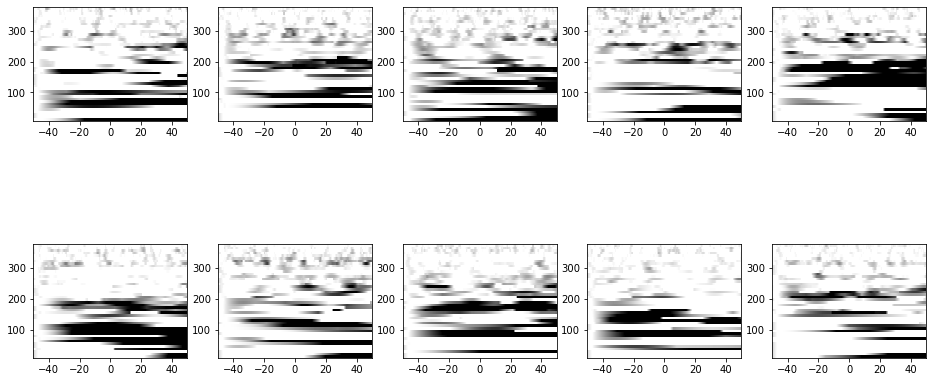

In [9]:
nsamp, nchan = 300000, 10
markers = range(30000, 30000*5, 30000)
fs = 30000
data_mat = np.random.randn(nsamp, nchan)
plot_spectrogram_matrix(data_mat, f, fs, markers, 2, 5)
plt.show()